In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 시스템에 설치된 폰트 목록 출력
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    print(fm.FontProperties(fname=font).get_name(), font)

MT Extra C:\Windows\Fonts\MTEXTRA.TTF
Lucida Fax C:\Windows\Fonts\LFAX.TTF
Comic Sans MS C:\Windows\Fonts\comici.ttf
Candara C:\Windows\Fonts\Candarai.ttf
OCR A Extended C:\Windows\Fonts\OCRAEXT.TTF
Yu Gothic C:\Windows\Fonts\YuGothR.ttc
Sitka C:\Windows\Fonts\SitkaVF-Italic.ttf
Blackadder ITC C:\Windows\Fonts\ITCBLKAD.TTF
Georgia C:\Windows\Fonts\georgiaz.ttf
Castellar C:\Windows\Fonts\CASTELAR.TTF
Edwardian Script ITC C:\Windows\Fonts\ITCEDSCR.TTF
Bodoni MT C:\Windows\Fonts\BOD_CI.TTF
Gill Sans Ultra Bold Condensed C:\Windows\Fonts\GILLUBCD.TTF
Segoe Print C:\Windows\Fonts\segoepr.ttf
Franklin Gothic Medium C:\Windows\Fonts\framd.ttf
Rockwell C:\Windows\Fonts\ROCKB.TTF
Goudy Old Style C:\Windows\Fonts\GOUDOSI.TTF
Curlz MT C:\Windows\Fonts\CURLZ___.TTF
Cambria C:\Windows\Fonts\cambriaz.ttf
Juice ITC C:\Windows\Fonts\JUICE___.TTF
Impact C:\Windows\Fonts\impact.ttf
Eras Demi ITC C:\Windows\Fonts\ERASDEMI.TTF
Hancom Gothic C:\Windows\Fonts\Hancom Gothic Regular.ttf
Tw Cen MT Condensed C:

In [2]:
import pandas as pd
import numpy as np

# !pip install pykrx
from pykrx import stock

from tqdm import tqdm
import time

import seaborn as sns

In [3]:
df = pd.read_csv("./meta_data.csv")
df

,종목코드,종목명,시장구분,업종명,종가,대비,등락률,시가총액
0,120110,코오롱인더,KOSPI,화학,36550,-50,-0.14,1005822776050
1,150,두산,KOSPI,기타금융,137000,4100,3.09,2263765395000
2,24720,콜마홀딩스,KOSPI,기타금융,8250,20,0.24,303348540000
3,24720,콜마홀딩스,KOSPI,기타금융,8250,20,0.24,303348540000
4,4560,현대비앤지스틸,KOSPI,철강금속,20950,600,2.95,315901090450
...,...,...,...,...,...,...,...,...
141,4990,롯데지주,KOSPI,기타금융,26500,-300,-1.12,2780094780500
142,267260,HD현대일렉트릭,KOSPI,전기전자,255000,15000,6.25,9192019425000
143,1740,SK네트웍스,KOSPI,유통업,5540,-20,-0.36,1225879577080
144,5930,삼성전자,KOSPI,전기전자,78600,3100,4.11,469224908430000


In [4]:
df['종목코드'] = df['종목코드'].astype(str).str.zfill(6)

In [5]:
import numpy as np 
from statsmodels import regression
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
import math
import pandas as pd 
import pandas_datareader as pdr 

In [6]:
sector_counts = df.groupby('업종명').size().reset_index(name='종목수')

print(sector_counts)

      업종명  종목수
0     건설업    6
1      기계    3
2    기타금융   20
3      보험    4
4   비금속광물    4
5    서비스업   11
6    섬유의복    1
7    운수장비   10
8   운수창고업    6
9     유통업   13
10     은행    2
11   음식료품    3
12    의약품    7
13  전기가스업    3
14   전기전자   13
15   종이목재    2
16     증권    5
17   철강금속    7
18    통신업    2
19     화학   24


In [7]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import networkx as nx

In [8]:
def create_graph_with_correlation(df, start, end):
    G = nx.Graph()
    
    # 모든 주식의 종가 데이터 가져오기
    stock_prices = {}
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        code = row["종목코드"]
        name = row["종목명"]
        sector = row["업종명"]
        asset = fdr.DataReader(code, start, end)
        stock_prices[code] = asset['Close']
    
    # 가장 긴 공통 기간 찾기
    min_date = max([prices.index.min() for prices in stock_prices.values()])
    max_date = min([prices.index.max() for prices in stock_prices.values()])
    
    # 공통 기간 내의 데이터를 기준으로 필터링
    common_dates = pd.date_range(start=min_date, end=max_date)
    print(f"Common date range: {min_date} to {max_date}")

    filtered_prices = {}
    for code in stock_prices:
        filtered_prices[code] = stock_prices[code].reindex(common_dates).dropna()
    
    # 시가총액 상위 50개 종목 선택
    valid_codes = [code for code in filtered_prices if len(filtered_prices[code]) > 0]
    top_50_df = df[df['종목코드'].isin(valid_codes)].nlargest(50, '시가총액')

    print(f"Valid codes after filtering: {len(valid_codes)}")
    print(f"Top 50 codes selected: {len(top_50_df)}")

    # 시가총액 상위 50개 종목에 대해 다시 종가 데이터를 가져오기
    stock_prices_top_50 = {code: filtered_prices[code] for code in top_50_df['종목코드']}

    for idx, row in tqdm(top_50_df.iterrows(), total=top_50_df.shape[0]):
        code = row["종목코드"]
        name = row["종목명"]
        sector = row["업종명"]
        
        # 그래프 노드에 종목명과 업종명 추가
        G.add_node(name, sector=sector)
    
    codes = list(stock_prices_top_50.keys())
    edge_count = 0
    for i in range(len(codes)):
        for j in range(i + 1, len(codes)):
            code_i = codes[i]
            code_j = codes[j]
            
            # 두 종목의 종가 데이터 가져오기
            prices_i = stock_prices_top_50[code_i]
            prices_j = stock_prices_top_50[code_j]
            
            # 상관 관계 계산
            if len(prices_i) > 1 and len(prices_j) > 1:  # 최소한 두 개의 데이터 포인트가 있는 경우
                correlation = prices_i.corr(prices_j)
                if not np.isnan(correlation) and correlation > 0.5:  # 상관 관계가 높은 경우만 엣지 추가
                    G.add_edge(df.loc[df['종목코드'] == code_i, '종목명'].values[0], 
                               df.loc[df['종목코드'] == code_j, '종목명'].values[0], 
                               weight=correlation)
                    edge_count += 1
    
    print(f"Total edges added: {edge_count}")
    return G


In [9]:
start_date = '2020-01-18'
end_date = '2020-03-18'

G = create_graph_with_correlation(df, start_date, end_date)

num_nodes = G.number_of_nodes()

print(f"Number of nodes in the graph: {num_nodes}")


  0%|          | 0/146 [00:00<?, ?it/s]

100%|██████████| 146/146 [02:14<00:00,  1.09it/s]


Common date range: 2020-01-20 00:00:00 to 2020-03-18 00:00:00
Valid codes after filtering: 129
Top 50 codes selected: 50


100%|██████████| 50/50 [00:00<00:00, 6243.75it/s]


Total edges added: 834
Number of nodes in the graph: 45


In [10]:
print("Edge weights:")
for (u, v, weight) in G.edges(data=True):
    print(f"({u}, {v}): {weight['weight']}")

Edge weights:
(삼성전자, 삼성바이오로직스): 0.6153107300227019
(삼성전자, 기아): 0.941824048681625
(삼성전자, NAVER): 0.9140804629382291
(삼성전자, LG화학): 0.6164824993886606
(삼성전자, 포스코퓨처엠): 0.9074578793425683
(삼성전자, 현대모비스): 0.9557322277404264
(삼성전자, 신한지주): 0.9042652847936025
(삼성전자, 카카오): 0.5469561049489594
(삼성전자, 삼성생명): 0.940829958398468
(삼성전자, 하나금융지주): 0.9550967119966941
(삼성전자, LG전자): 0.9616702260721198
(삼성전자, LG): 0.948354751823854
(삼성전자, 한화에어로스페이스): 0.9655936191099843
(삼성전자, SK): 0.9402036517122357
(삼성전자, 삼성에스디에스): 0.9624308268171066
(삼성전자, 삼성전기): 0.8982059978888467
(삼성전자, SK텔레콤): 0.9062403146690534
(삼성전자, 기업은행): 0.9249254535914617
(삼성전자, SK이노베이션): 0.9607275421483623
(삼성전자, 우리금융지주): 0.945333942445651
(삼성전자, 두산에너빌리티): 0.926995347154832
(삼성전자, 고려아연): 0.7572460516523574
(삼성전자, HD현대일렉트릭): 0.9628039146939505
(삼성전자, HD한국조선해양): 0.9614795208178051
(삼성전자, S-Oil): 0.9199576237666955
(삼성전자, 삼성중공업): 0.9560471137332629
(삼성전자, 포스코인터내셔널): 0.9657964605520297
(삼성전자, 대한항공): 0.9101906560477359
(삼성전자, 한국타이어앤테크놀로지): 0.9418424887

In [11]:
font_path = "C:/Windows/Fonts/malgun.ttf"  # 폰트 파일 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

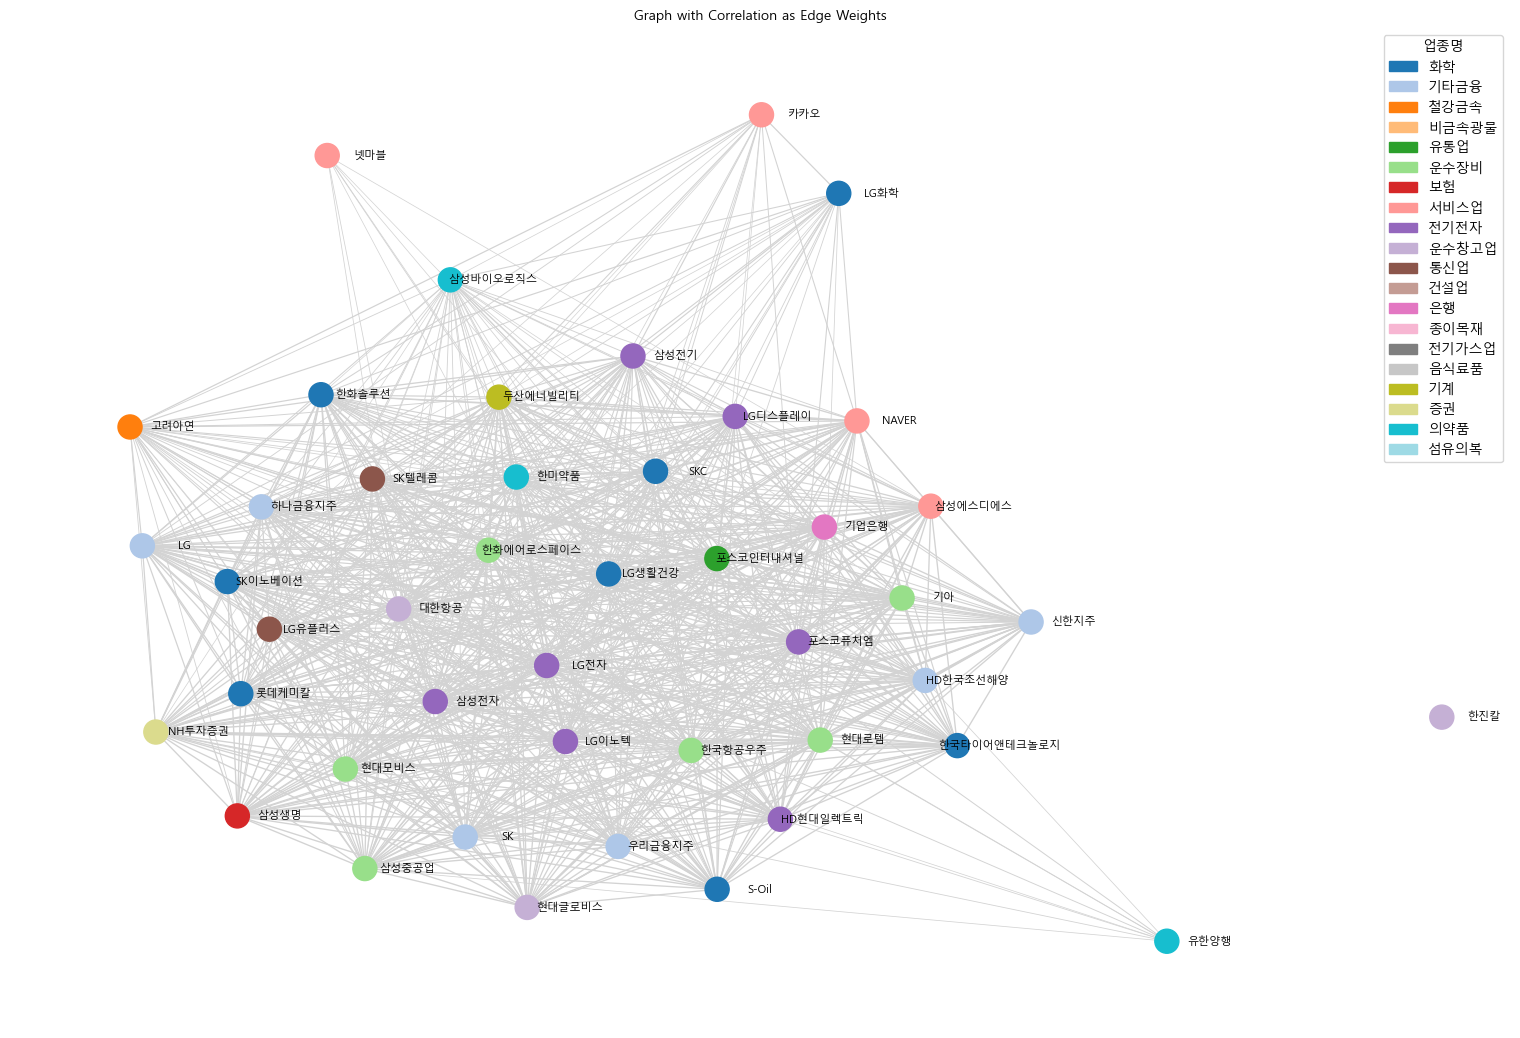

In [12]:
sectors = pd.unique(df["업종명"])
color_map = plt.get_cmap('tab20', len(sectors))
sector_color = {sector: color_map(i) for i, sector in enumerate(sectors)}

node_colors = [sector_color[G.nodes[node]['sector']] for node in G.nodes]

legend_patches = [mpatches.Patch(color=sector_color[sector], label=sector) for sector in sectors]

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=2)  # k 값을 조정하여 노드 간 거리 조정
weights = nx.get_edge_attributes(G, 'weight').values()

# 라벨 위치 조정
labels = {node: node for node in G.nodes}
nx.draw(G, pos, with_labels=False, node_color=node_colors, edge_color='lightgray', width=list(weights))
for p in pos:  # 라벨을 노드 옆에 배치
    pos[p][0] += 0.05
nx.draw_networkx_labels(G, pos, labels, font_family=font_prop.get_name(), font_size=8)

plt.title('Graph with Correlation as Edge Weights', fontproperties=font_prop)
plt.legend(handles=legend_patches, loc='best', title='업종명', prop=font_prop)
plt.show()

# MST

In [13]:
mst = nx.minimum_spanning_tree(G)

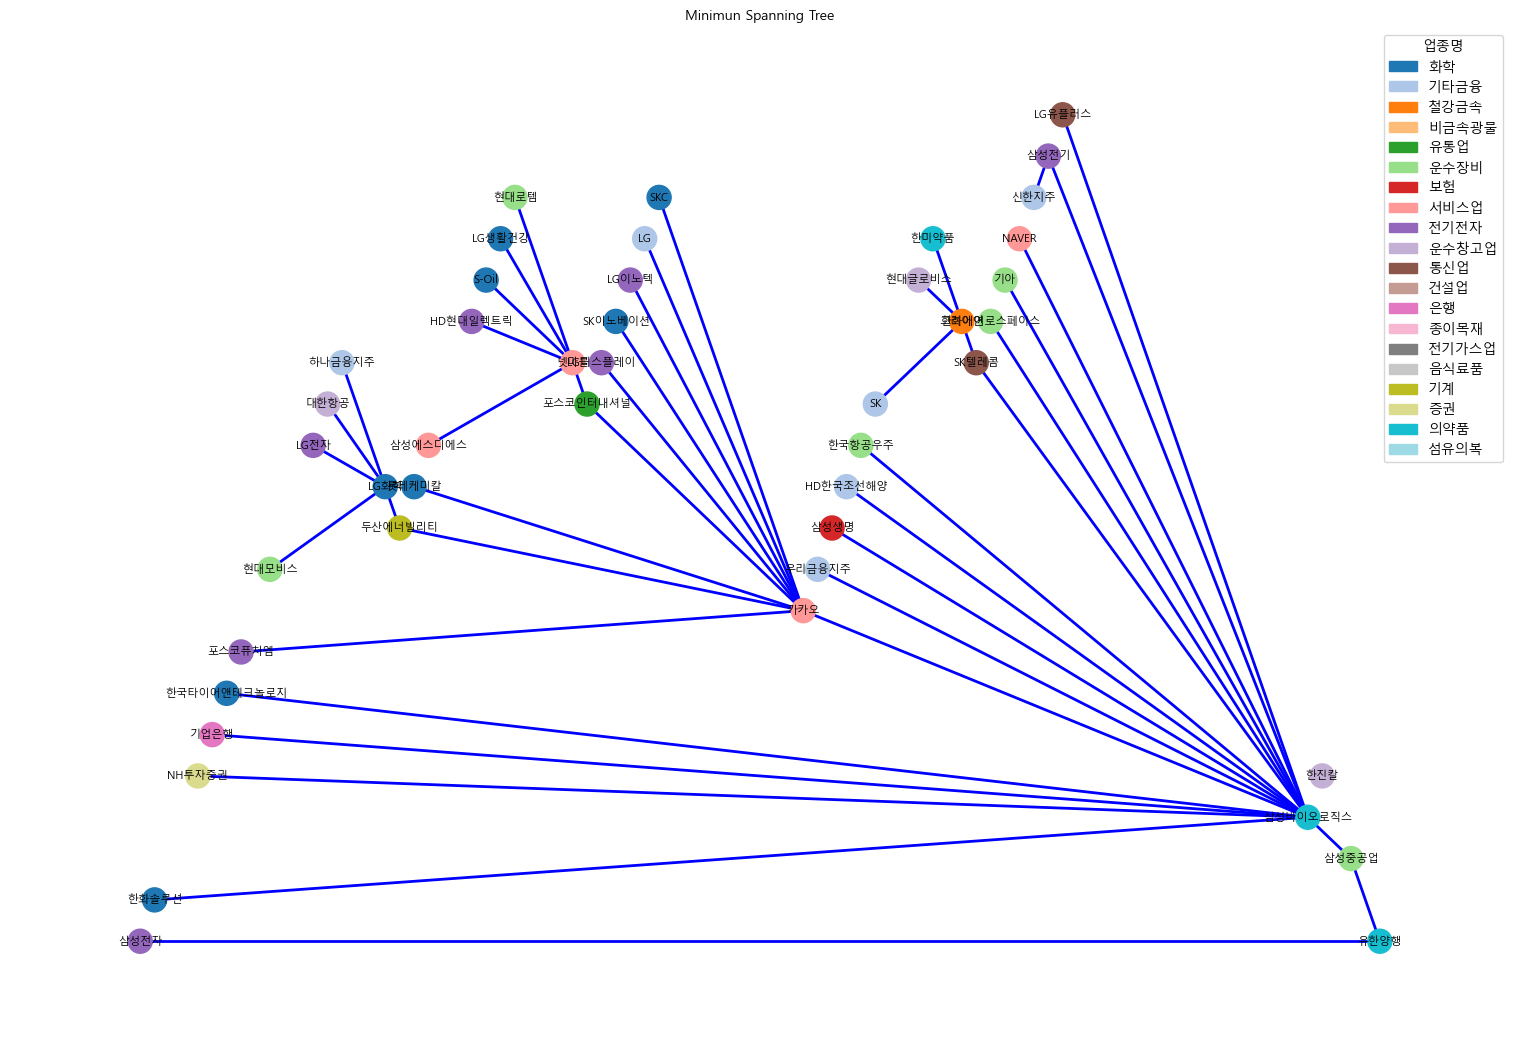

In [14]:
plt.figure(figsize=(15, 10))  
pos = nx.planar_layout(mst)  # 엣지 교차를 줄이기 위해 planar_layout 사용

nx.draw(mst, pos, with_labels=False, node_color=node_colors, edge_color='blue', width=2, node_size=300)
nx.draw_networkx_labels(mst, pos, labels={node: node for node in mst.nodes()}, font_family=font_prop.get_name(), font_size=8)
plt.title("Minimun Spanning Tree", fontproperties=font_prop)
plt.legend(handles=legend_patches, loc='best', title='업종명', prop=font_prop)
plt.show()

# Centrality Analysis

In [15]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

In [16]:
centrality_df = pd.DataFrame({
    '종목코드': list(G.nodes),
    '업종명': [G.nodes[node]['sector'] for node in G.nodes],
    'Degree Centrality': [degree_centrality[node] for node in G.nodes],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes]
})

In [17]:
for centrality in ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']:
    print(f"Top 10 {centrality}")
    display(centrality_df[['종목코드', '업종명', centrality]].nlargest(10, centrality))
    print("\n")

Top 10 Degree Centrality


,종목코드,업종명,Degree Centrality
0,삼성전자,전기전자,0.977273
27,포스코인터내셔널,유통업,0.954545
28,대한항공,운수창고업,0.954545
31,LG생활건강,화학,0.954545
37,현대로템,운수장비,0.954545
3,NAVER,서비스업,0.931818
5,포스코퓨처엠,전기전자,0.931818
12,LG,기타금융,0.931818
16,삼성전기,전기전자,0.931818
19,SK이노베이션,화학,0.931818




Top 10 Betweenness Centrality


,종목코드,업종명,Betweenness Centrality
0,삼성전자,전기전자,0.012509
28,대한항공,운수창고업,0.009675
37,현대로템,운수장비,0.009675
23,HD현대일렉트릭,전기전자,0.008239
27,포스코인터내셔널,유통업,0.007195
31,LG생활건강,화학,0.007195
15,삼성에스디에스,서비스업,0.004334
25,S-Oil,화학,0.004125
17,SK텔레콤,통신업,0.003728
24,HD한국조선해양,기타금융,0.003728




Top 10 Closeness Centrality


,종목코드,업종명,Closeness Centrality
0,삼성전자,전기전자,0.977273
27,포스코인터내셔널,유통업,0.955062
28,대한항공,운수창고업,0.955062
31,LG생활건강,화학,0.955062
37,현대로템,운수장비,0.955062
3,NAVER,서비스업,0.933838
5,포스코퓨처엠,전기전자,0.933838
12,LG,기타금융,0.933838
16,삼성전기,전기전자,0.933838
19,SK이노베이션,화학,0.933838




Top 10 Eigenvector Centrality


,종목코드,업종명,Eigenvector Centrality
0,삼성전자,전기전자,0.160755
27,포스코인터내셔널,유통업,0.159868
31,LG생활건강,화학,0.159868
34,LG디스플레이,전기전자,0.159076
35,LG이노텍,전기전자,0.159076
38,SKC,화학,0.159076
39,롯데케미칼,화학,0.159076
40,LG유플러스,통신업,0.159076
41,한화솔루션,화학,0.159076
3,NAVER,서비스업,0.159076


# Influence Maximization

In [18]:
import random

# 독립적 연접 모델을 사용한 영향 평가 함수
def independent_cascade(G, seed_nodes, steps=1000):
    influenced_nodes = set(seed_nodes)
    new_active = set(seed_nodes)
    for _ in range(steps):
        if not new_active:
            break
        next_active = set()
        for node in new_active:
            for neighbor in G.neighbors(node):
                if neighbor not in influenced_nodes and random.random() < G[node][neighbor]['weight']:
                    next_active.add(neighbor)
        influenced_nodes.update(next_active)
        new_active = next_active
    return len(influenced_nodes)

In [19]:
# Greedy Algorithm을 사용한 시드 노드 선택
def greedy_algorithm(G, k, steps=1000):
    seed_nodes = []
    for _ in tqdm(range(k)):
        best_node = None
        max_influence = -1
        for node in tqdm(G.nodes):
            if node not in seed_nodes:
                influence = independent_cascade(G, seed_nodes + [node], steps)
                if influence > max_influence:
                    best_node = node
                    max_influence = influence
        seed_nodes.append(best_node)
    return seed_nodes

In [20]:
# 시드 노드 수 설정
k = 1

# Greedy Algorithm을 사용하여 시드 노드 선택
seed_nodes = greedy_algorithm(G, k)
print(f"Selected seed nodes: {seed_nodes}")

100%|██████████| 1/1 [00:00<00:00, 61.28it/s]

Selected seed nodes: ['삼성전자']


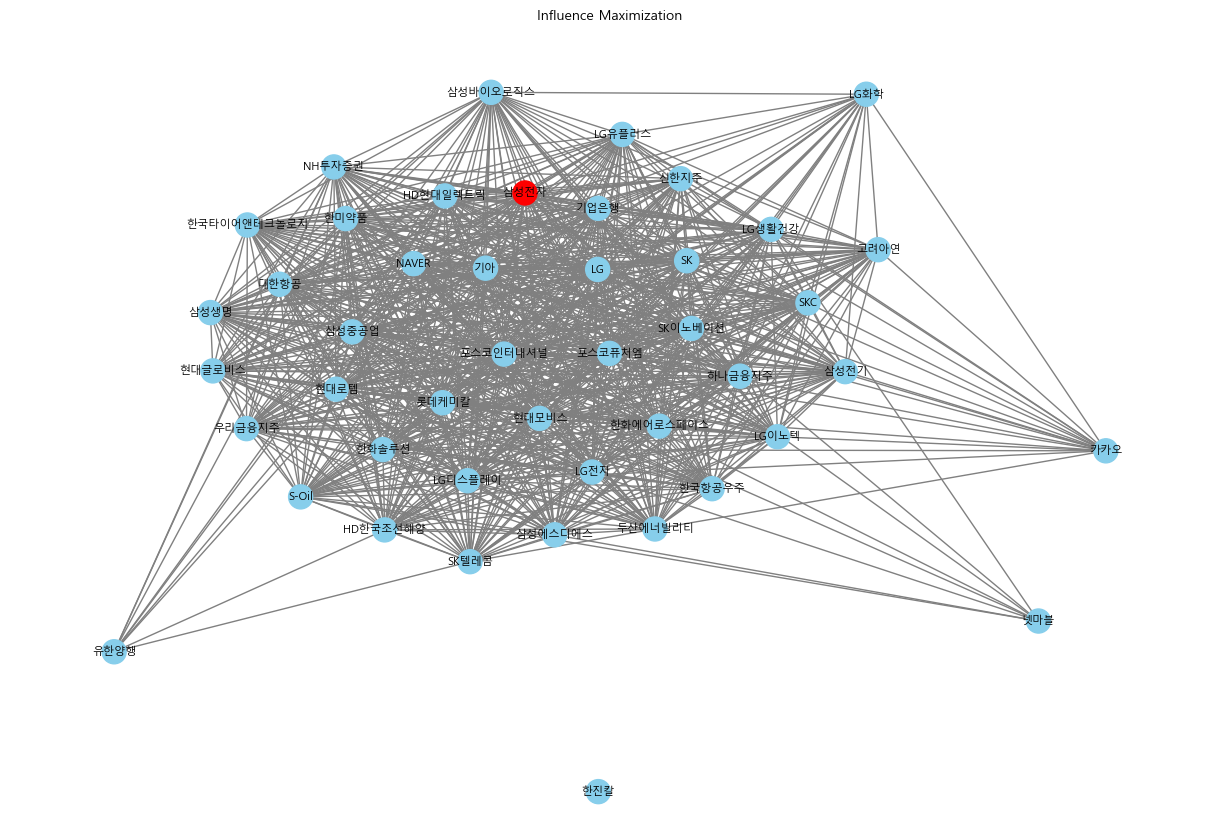

In [21]:
font_path = "C:/Windows/Fonts/malgun.ttf"  # 폰트 파일 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

# 시각화 (선택된 시드 노드를 강조하여 표시)
pos = nx.spring_layout(G, k=2)

node_colors = ['red' if node in seed_nodes else 'skyblue' for node in G.nodes]

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray', node_size=300, font_size=8, font_family=font_prop.get_name())  # 노드 크기 조정
plt.title("Influence Maximization", fontproperties=font_prop)
plt.show()

# Community Detection

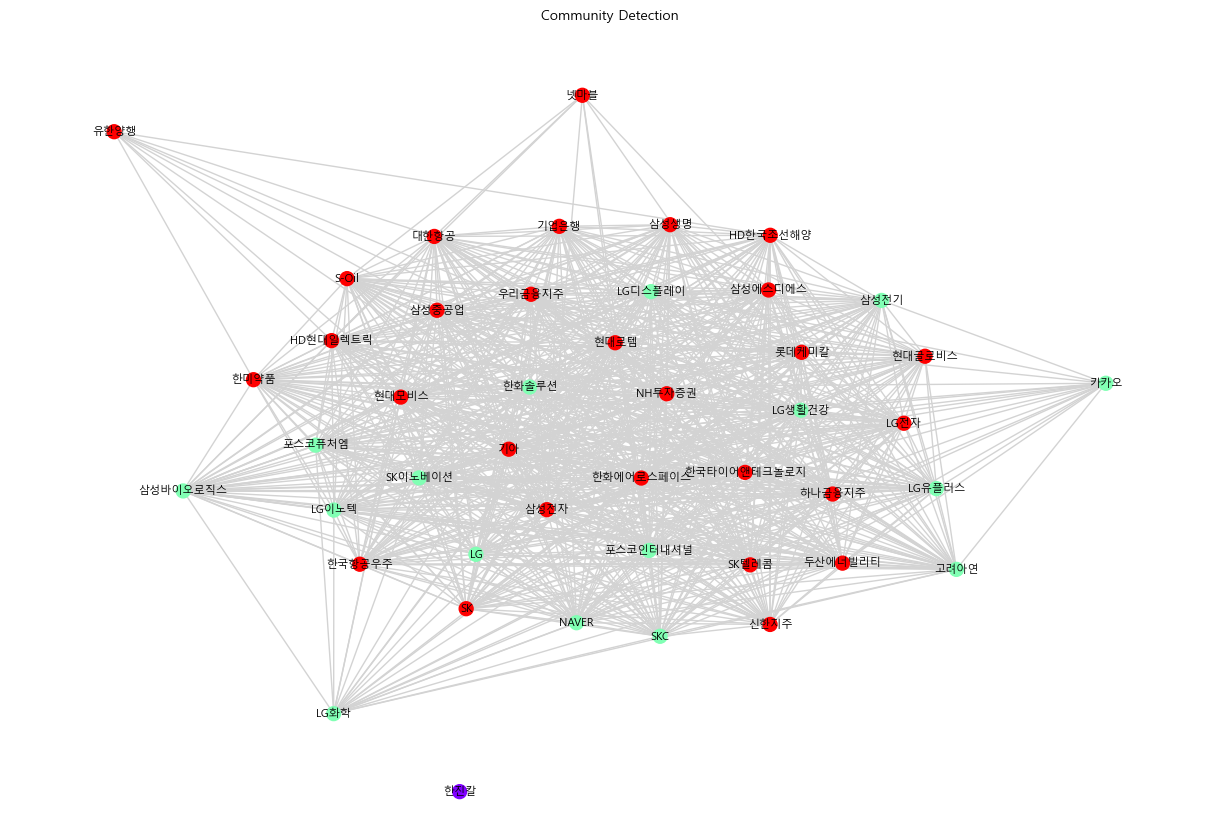

In [22]:
import community as community_louvain

partition = community_louvain.best_partition(G)

# 커뮤니티별로 노드 색상 지정
colors = [partition[node] for node in G.nodes()]

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 폰트 파일 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

# 그래프 시각화
pos = nx.spring_layout(G, k=2)
plt.figure(figsize=(12, 8))

nx.draw(G, pos, node_color=colors, with_labels=True, cmap=plt.cm.rainbow, node_size=100, edge_color='lightgray', font_size=8, font_family=font_prop.get_name())
plt.title("Community Detection", fontproperties=font_prop)

plt.show()

In [23]:
community_df = pd.DataFrame.from_dict(partition, orient='index', columns=['커뮤니티'])
community_df['종목명'] = community_df.index
community_df.reset_index(drop=True, inplace=True)

# 업종명 추가
community_df = community_df.merge(df[['종목명', '업종명']], on='종목명')

# 커뮤니티와 업종명 카운트 피벗 테이블 생성
pivot_table = community_df.pivot_table(index='커뮤니티', columns='업종명', aggfunc='size', fill_value=0)

# 커뮤니티 이름을 "community 1", "community 2" 형식으로 변경
pivot_table.index = [f"community {i+1}" for i in range(len(pivot_table))]

# 결과 출력
pivot_table

업종명,기계,기타금융,보험,서비스업,운수장비,운수창고업,유통업,은행,의약품,전기전자,증권,철강금속,통신업,화학
community 1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
community 2,0,1,0,3,0,0,1,0,1,5,0,1,1,6
community 3,1,5,1,2,7,3,0,1,2,3,1,0,1,3
